# Integrating data using SCALE v2

The following tutorial demonstrates how to use SCALE v2 for *integrating* data and *projection* new data `adata_query` onto an annotated reference `adata_ref`. 
    
There are four parts of this tutorial:
* **Seeing the batch effect.** This part will show the batch effects of eight pancreas datasets that used in SCALE v2 manuscript.
* **Integrating data using SCALEX.** This part will show you how to perform batch correction and construct a reference batch `adata_ref` using SCALEX.
* **Mapping onto a reference batch using projection function.** The third part will describe the usage of projection function in SCALEX to map three batches query dataset `adata_query` onto the reference batch `adata_ref` you construetd in part two.
* **Visualizing distributions across batches.** Often, batches correspond to experiments that one wants to compare. SCALE v2 offers [plot_umap](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) function to convenient visualize for this. 

In [1]:
from scalex.function import SCALEX
from scalex.visualize import plot_umap
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sci
import anndata as ad

In [2]:
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)
sc.logging.print_header()
plt.rcParams['axes.unicode_minus']=False

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.3


## Seeing the batch effect

The following data has been used in the ???, has been used here, was curated here and can be downloaded from here (???).

It contains data for human pancreas from ??? different studies (????), which have been used in the seminal papers on single-cell dataset integration (???) and many times ever since.

In [3]:
adata_raw=sc.read('/home/data/pancreas/pancreas.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 16401 × 14895
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol'

Inspect the batches contained in the dataset.

In [4]:
adata_raw.obs.batch.value_counts()

pancreas_indrop3       3605
pancreas_celseq2       3072
pancreas_smartseq2     2394
pancreas_indrop1       1937
pancreas_celseq        1728
pancreas_indrop2       1724
pancreas_indrop4       1303
pancreas_fluidigmc1     638
Name: batch, dtype: int64

The data processing procedure is according to the scanpy tutorial [[Preprocessing and clustering 3k PBMCs]](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing-and-clustering-3k-PBMCs).

In [5]:
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=3)
adata_raw = adata_raw[:, [gene for gene in adata_raw.var_names if not str(gene).startswith(tuple(['ERCC', 'MT-', 'mt-']))]]
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(adata_raw, min_mean=0.0125, max_mean=3, min_disp=0.5)    
adata_raw.raw = adata_raw
adata_raw = adata_raw[:, adata_raw.var.highly_variable]
sc.pp.scale(adata_raw, max_value=10)
sc.pp.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)

filtered out 1124 cells that have less than 600 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


We observe a batch effect.

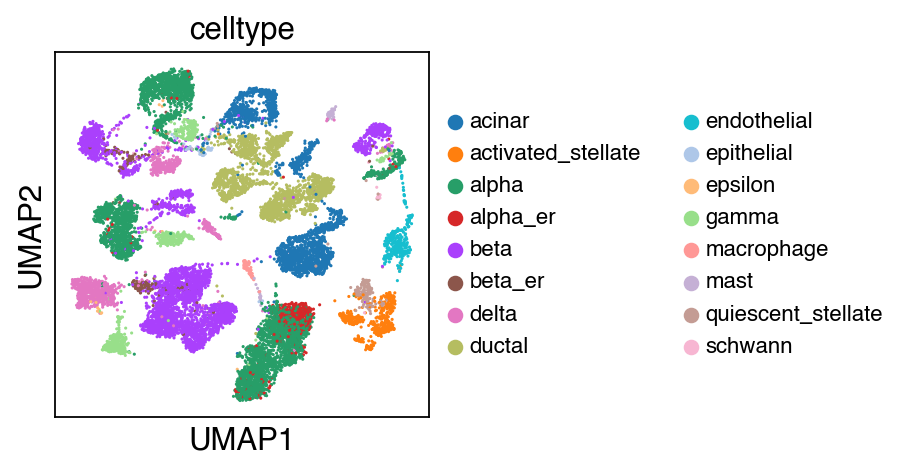

In [6]:
sc.pl.umap(adata_raw,color=['celltype'],legend_fontsize=10)

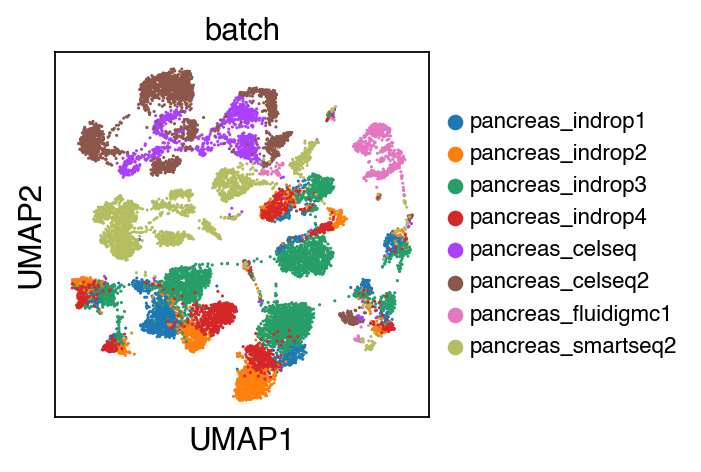

In [7]:
sc.pl.umap(adata_raw,color=['batch'],legend_fontsize=10)

In [8]:
adata_raw

AnnData object with n_obs × n_vars = 15277 × 2086
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Integrating data using SCALEX

The batch effects can be well-resolved using SCALEX.

In [9]:
adata_ref=SCALEX('/home/data/pancreas/pancreas.h5ad',batch_name='batch',min_genes=600, min_cells=3, outdir='output/',show=False,gpu=6)

2021-03-08 18:45:50,342 - root - INFO - Raw dataset shape: (16401, 14895)
2021-03-08 18:45:50,344 - root - INFO - Preprocessing
2021-03-08 18:45:50,371 - root - INFO - Filtering cells


filtered out 1124 cells that have less than 600 genes expressed


Trying to set attribute `.obs` of view, copying.
2021-03-08 18:45:52,766 - root - INFO - Filtering genes
2021-03-08 18:45:54,346 - root - INFO - Normalizing total per cell


normalizing counts per cell
    finished (0:00:00)


2021-03-08 18:45:54,602 - root - INFO - Log1p transforming
2021-03-08 18:45:55,516 - root - INFO - Finding variable genes


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


2021-03-08 18:45:59,972 - root - INFO - Batch specific maxabs scaling
2021-03-08 18:46:01,984 - root - INFO - Processed dataset shape: (15277, 2000)
2021-03-08 18:46:02,070 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=2000, out_features=1024, bias=True)
          (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
      )
    )
    (mu_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
    (var_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
  )
  (decoder): NN(
    (net): ModuleList(
      (0): Block(
        (fc): Linear(in_features=10, out_features=2000, bias=True)
        (norm): DSBatchNorm(
          (bns): ModuleList(

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [10]:
adata_ref

AnnData object with n_obs × n_vars = 15277 × 2000
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'batch_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

While there seems to be some strong batch-effect in all cell types, SCALEX can integrate them homogeneously.

In [13]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

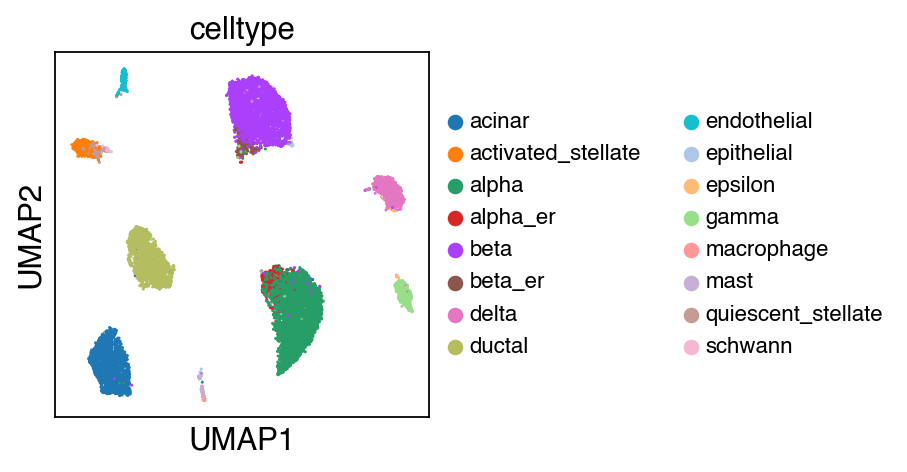

In [14]:
sc.pl.umap(adata_ref,color=['celltype'],legend_fontsize=10)

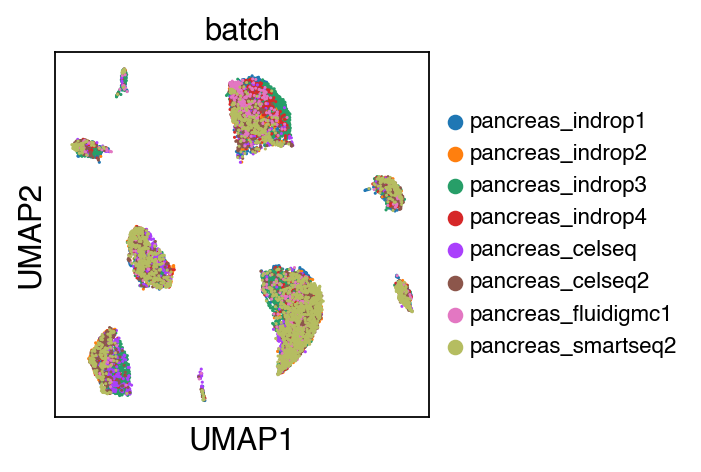

In [15]:
sc.pl.umap(adata_ref,color=['batch'],legend_fontsize=10)

## Mapping onto a reference batch using projection function

In [16]:
adata_query=sc.read('/home/data/pancreas/pancreas_test.h5ad')
adata_query

AnnData object with n_obs × n_vars = 23963 × 31884
    obs: 'batch', 'celltype', 'disease', 'donor', 'protocol'

Inspect the batches contained in `adata_query`.

In [17]:
adata_query.obs.batch.value_counts()

pancreas_gse114297    20784
pancreas_gse81547      2544
pancreas_gse83139       635
Name: batch, dtype: int64

SCALEX provides a projection function for mapping new data `adata_query` onto the reference batch `adata_ref`.

In [18]:
adata=SCALEX('/home/data/pancreas/pancreas_test.h5ad',batch_name='batch',min_genes=600, min_cells=3,
       outdir='projection/', projection='/home/liyuzhe/Notebook/SCALEX_tutorial/output/',show=False,gpu=6)

2021-03-08 18:58:28,441 - root - INFO - Raw dataset shape: (23963, 31884)
2021-03-08 18:58:28,441 - root - INFO - Raw dataset shape: (23963, 31884)
2021-03-08 18:58:28,443 - root - INFO - Preprocessing
2021-03-08 18:58:28,443 - root - INFO - Preprocessing
2021-03-08 18:58:28,485 - root - INFO - Filtering cells
2021-03-08 18:58:28,485 - root - INFO - Filtering cells


filtered out 219 cells that have less than 600 genes expressed


Trying to set attribute `.obs` of view, copying.
2021-03-08 18:58:30,983 - root - INFO - Filtering genes
2021-03-08 18:58:30,983 - root - INFO - Filtering genes
2021-03-08 18:58:32,426 - root - INFO - Normalizing total per cell
2021-03-08 18:58:32,426 - root - INFO - Normalizing total per cell


normalizing counts per cell
    finished (0:00:00)


2021-03-08 18:58:32,789 - root - INFO - Log1p transforming
2021-03-08 18:58:32,789 - root - INFO - Log1p transforming
2021-03-08 18:58:34,029 - root - INFO - Finding variable genes
2021-03-08 18:58:34,029 - root - INFO - Finding variable genes


There are 2000 gene in selected genes


2021-03-08 18:58:37,613 - root - INFO - Batch specific maxabs scaling
2021-03-08 18:58:37,613 - root - INFO - Batch specific maxabs scaling
2021-03-08 18:58:40,428 - root - INFO - Processed dataset shape: (23744, 2000)
2021-03-08 18:58:40,428 - root - INFO - Processed dataset shape: (23744, 2000)
2021-03-08 18:58:44,840 - root - INFO - Output dir: projection//
2021-03-08 18:58:44,840 - root - INFO - Output dir: projection//
... storing 'batch' as categorical
... storing 'celltype' as categorical
... storing 'disease' as categorical
... storing 'donor' as categorical
... storing 'library' as categorical
... storing 'protocol' as categorical
... storing 'leiden' as categorical
2021-03-08 18:58:49,213 - root - INFO - Plot umap
2021-03-08 18:58:49,213 - root - INFO - Plot umap


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


Load integrated data `adata` that contained `adata_ref` and `adata_query`.

In [19]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

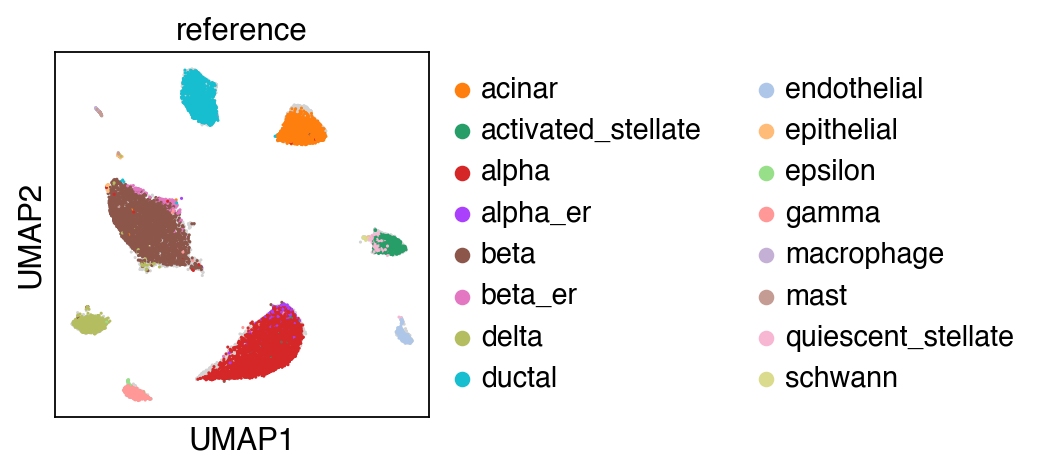

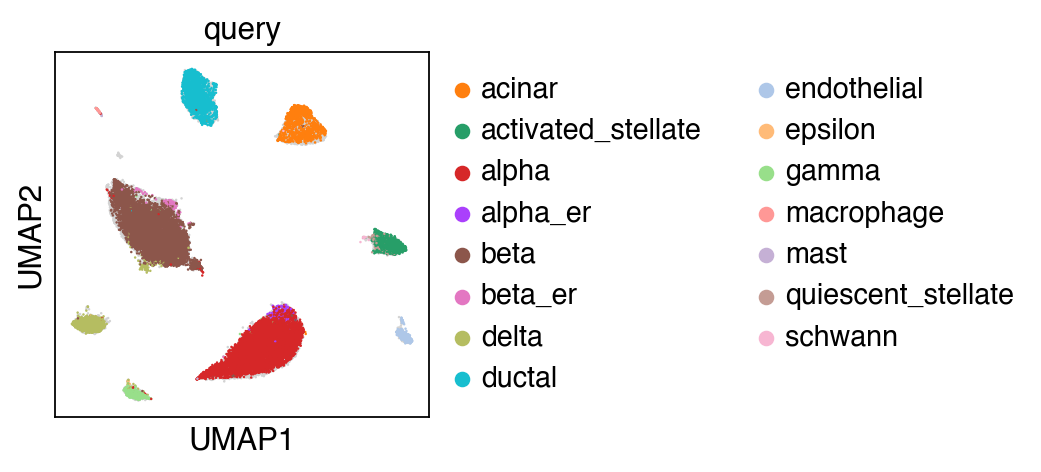

In [21]:
plot_umap(adata,cond1='projection')

In [22]:
adata

AnnData object with n_obs × n_vars = 39021 × 2000
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes', 'leiden', 'projection'
    var: 'n_cells-reference', 'highly_variable-reference', 'means-reference', 'dispersions-reference', 'dispersions_norm-reference', 'highly_variable_nbatches-reference', 'highly_variable_intersection-reference'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

Inspect the batches contained in `adata`.

In [23]:
adata.obs.batch.value_counts()

pancreas_gse114297     20573
pancreas_indrop3        3605
pancreas_gse81547       2536
pancreas_celseq2        2440
pancreas_smartseq2      2394
pancreas_indrop1        1937
pancreas_indrop2        1724
pancreas_indrop4        1303
pancreas_celseq         1236
pancreas_fluidigmc1      638
pancreas_gse83139        635
Name: batch, dtype: int64

## Visualizing distributions across batches

Trying to set attribute `.uns` of view, copying.


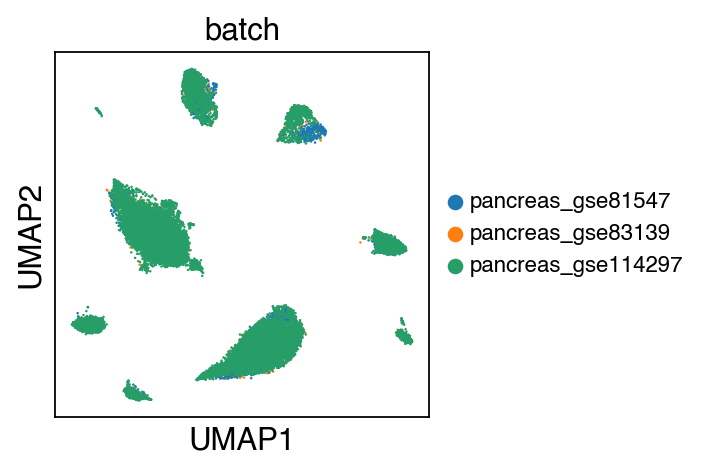

Trying to set attribute `.obs` of view, copying.


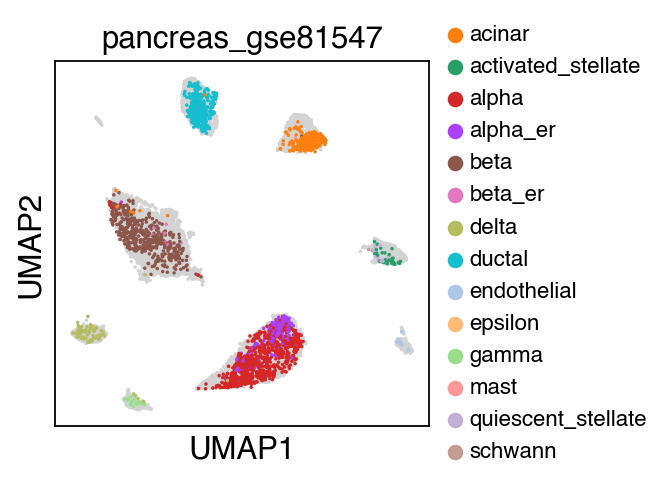

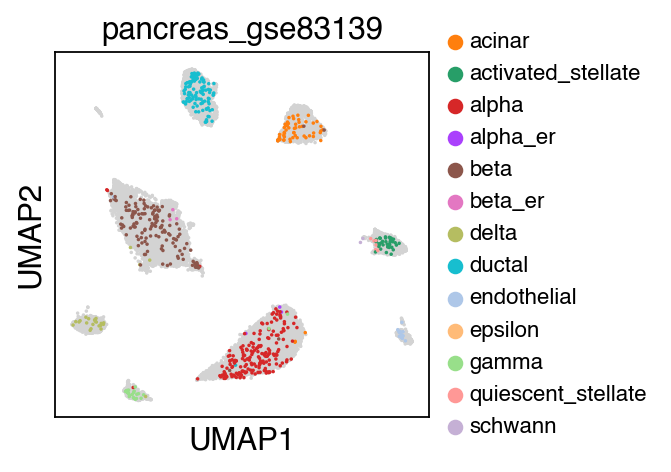

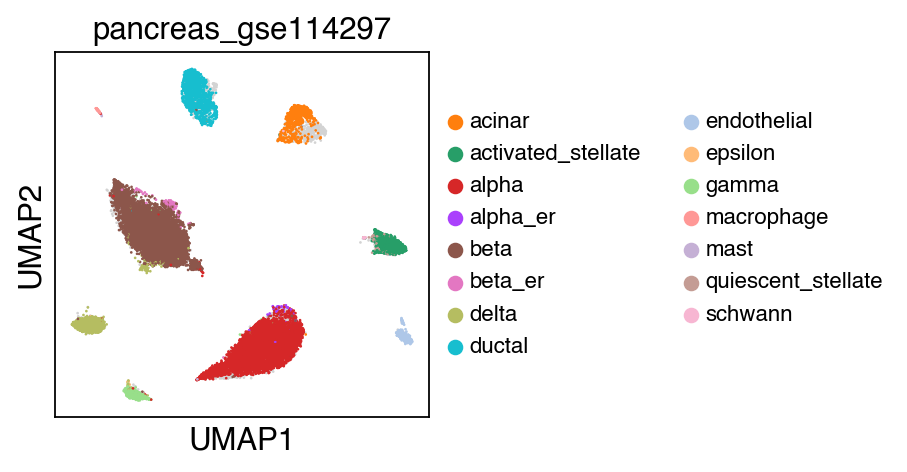

In [24]:
sc.pl.umap(adata[adata.obs.batch.isin(['pancreas_gse114297','pancreas_gse81547','pancreas_gse83139'])],color='batch',legend_fontsize=10)
plot_umap(adata[adata.obs.batch.isin(['pancreas_gse114297','pancreas_gse81547','pancreas_gse83139'])],legend_fontsize=10)